In [28]:
# from dlab.dev import postprocess as pp
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import os

from open_ephys.analysis import Session

In [23]:
class UnitData:
    def __init__(self,recording_path) -> None:
        self.old_cwd       = os.getcwd()
        self.sampling_rate = 30000.0
        
        self.option234_xpositions           = np.zeros((192,2))
        self.option234_ypositions           = np.zeros((192,2))
        self.option234_positions            = np.zeros((384,2))
        self.option234_positions[:,0][::4]  = 21
        self.option234_positions[:,0][1::4] = 53
        self.option234_positions[:,0][2::4] = 5
        self.option234_positions[:,0][3::4] = 37
        self.option234_positions[:,1]       = np.floor(np.linspace(383,0,384)/2) * 20
        
        if 'recording' not in os.path.basename(recording_path):
            print('Please provide a path to a recording folder (e.g. /path/to/recording1)')
            
        self.recording_path = recording_path
        self.ap_folders     = glob(os.path.join(self.recording_path,'continuous','*AP'))
        
    def load(self,probe_depths=[],probes=[],acq='OpenEphys'):
        site_positions = self.option234_positions
        
        for i,PROBE in enumerate(probes):
            print(PROBE)
            probe_name = PROBE
            for folder in self.ap_folders:
                if 'Probe'+PROBE in folder:
                    probe_path = folder
            
            os.chdir(probe_path)
            
            if os.path.isfile('spike_seconds.npy'):
                spike_times = np.load('spike_seconds.npy')
            else:
                spike_times = np.load('spike_times.npy').flatten()
                if isinstance(spike_times[0],(np.uint64)):
                    if acq == 'OpenEphys':
                        try:
                            ts = np.load('timestamps.npy')
                        except: print('could not load timestamps.npy')
                        spike_times = ts[spike_times]
                        np.save('spike_seconds.npy',spike_times)
                        
                    else: print('SpikeGLX currently not supported')
                    
            try:
                cluster_info = pd.read_csv('cluster_info.tsv', delimiter='\t')
            except: 
                print('Unable to load cluster_info.tsv. Have you opened this data in Phy?')
                        
            spike_clusters  = np.load('spike_clusters.npy').flatten()
            spike_templates = np.load('spike_templates.npy')
            templates       = np.load('templates.npy')
            amplitudes      = np.load('amplitudes.npy')
            weights         = np.zeros(site_positions.shape)
            
            mean_templates = []
            xpos           = []
            ypos           = []
            all_weights    = []
            amps           = []
            times          = []
            
            
            for unit_id in cluster_info.cluster_id.values:
                #get mean template for each unit
                all_templates    = spike_templates[np.where(spike_clusters==unit_id)].flatten()
                template_idx     = np.unique(all_templates)
                mean_template    = np.mean(templates[template_idx],axis=0)
                
                mean_templates.append(mean_template)
                
                #Take weighted average of site positions where hweights is abs value of template for that channel
                #This gets us the x and y positions of the unit on the probe

                for channel in range(len(mean_template.T)):
                    weights[channel,:] = np.trapz(np.abs(mean_template.T[channel]))
            
                weights                /= weights.max()
                weights[weights < 0.25] = 0 #Where weights are low, set to 0
                x,y                     = np.average(site_positions,weights=weights,axis=0)
                all_weights.append(weights)
                xpos.append(x)
                ypos.append(y)
                
                amps.append(amplitudes[:,0][spike_clusters==unit_id])
                times.append(spike_times[spike_clusters==unit_id])
            
            
            probe_data = cluster_info.copy()
            
            probe_data.insert(1,'times',times)
            probe_data.insert(1,'amplitudes',amps)
            probe_data.insert(1,'weights',all_weights)
            probe_data.insert(1,'template',mean_templates)
            probe_data.insert(1,'ypos',ypos)
            probe_data.insert(1,'xpos',xpos)
            probe_data.insert(0,'probe',[probe_name]*len(probe_data))
            probe_data['depth'] = np.array(ypos)-3840+probe_depths[i]
            
            
            if 'unit_data' not in locals():
                unit_data = probe_data
                
            else:
                unit_data = pd.concat([unit_data,probe_data],ignore_index=True)
                unit_data.reset_index(inplace=True,drop=True)
                
            os.chdir(self.old_cwd)
        
        return unit_data
    
    def get_qMetrics(self,path):
        metrics_path = os.path.join(path,'qMetrics')
        if not os.path.isdir(metrics_path):
            print('Please provide path containing qMetrics folder')
        else:
            params = pd.read_parquet(os.path.join(metrics_path,'_bc_parameters._bc_qMetrics.parquet'))
            
            qMetrics = pd.read_parquet(os.path.join(metrics_path,'templates._bc_qMetrics.parquet'))
            
        return params, qMetrics


class StimData:
    def __init__(self,recording_path, recording_no = 0) -> None:
        self.old_cwd       = os.getcwd()
        self.sampling_rate = 30000.0
        
        if 'recording' not in os.path.basename(recording_path):
            print('Please provide a path to a recording folder (e.g. /path/to/recording1)')
            
        self.session_path = os.path.abspath(os.path.join(recording_path,*[os.pardir]*3))
        self.session      = Session(self.session_path)
        self.recording    = self.session.recordnodes[0].recordings[recording_no-1]
        
        events            = self.recording.events #DataFrame
        
        stim_events       = events[events.stream_index == events.stream_index.unique().max()]
        self.stim_rising  = stim_events[stim_events.state == 1]
        self.stim_falling = stim_events[stim_events.state == 0]
        
        self.digital_output = {}
        self.dlines         = np.sort(events.line.unique())
        
        for dl in self.dlines:
            self.digital_output[str(dl-1)] = self.stim_rising[self.stim_rising.line == dl].timestamp.values
    
    def plot(self):
        fig,ax = plt.subplots()
        for dline in self.digital_output:
            ax.plot(self.digital_output[dline],np.ones(len(self.digital_output[dline]))*int(dline),'-o',label=dline)
        plt.title('Digital Events')
        plt.ylabel('Digital Line')
        plt.xlabel('Time (s)')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()











# Get Unit Data

In [18]:
ap_folders     = glob(os.path.join(recording_path,'continuous','*AP'))
ap_folders

['G:/Grant/rotation/2023-09-20_14-25-05_eOPN3_33/Record Node 103/experiment1/recording1\\continuous\\Neuropix-PXI-106.ProbeA-AP',
 'G:/Grant/rotation/2023-09-20_14-25-05_eOPN3_33/Record Node 103/experiment1/recording1\\continuous\\Neuropix-PXI-106.ProbeB-AP',
 'G:/Grant/rotation/2023-09-20_14-25-05_eOPN3_33/Record Node 103/experiment1/recording1\\continuous\\Neuropix-PXI-106.ProbeC-AP']

In [21]:
units_df[units_df.probe=='B']

,probe,cluster_id,xpos,ypos,template,weights,amplitudes,times,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
381,B,0,44.496626,3178.594578,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[14.721253395080566, 13.39111042022705, 13.329...","[898.2871618587744, 914.3382928528056, 916.590...",1084.8,76.7,mua,78.350647,0,438.594578,1.015527,mua,10619,0
382,B,2,44.496626,3178.594578,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[11.004119873046875, 15.02967357635498, 18.804...","[1977.6300003017877, 6472.314253150281, 6486.2...",1353.0,49.4,mua,61.538380,0,438.594578,0.036149,noise,378,0
383,B,3,44.496626,3178.594578,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[15.286653518676758, 18.204349517822266, 10.97...","[897.7855370118482, 898.2848261986003, 900.022...",603.4,78.0,mua,45.920544,0,438.594578,0.898185,good,9392,0
384,B,4,44.496626,3178.594578,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[11.33564281463623, 19.246627807617188, 17.047...","[1462.4069229379975, 1544.6529869796082, 1584....",964.0,38.8,mua,54.153969,16,438.594578,0.150909,noise,1578,0
385,B,5,44.496626,3178.594578,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[21.0196590423584, 16.91954803466797, 16.66419...","[1747.9666052774046, 3213.625090308067, 3275.5...",2608.7,18.0,mua,62.035282,1,438.594578,0.118681,noise,1241,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,B,1311,44.496626,3178.594578,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[13.5220365524292, 13.6093168258667, 12.825294...","[899.9784548396858, 900.3986734441719, 911.824...",636.5,0.0,good,57.129475,55,438.594578,1.004720,good,10506,0
1171,B,1316,44.496626,3178.594578,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[25.215734481811523, 13.766027450561523, 17.23...","[902.803669201984, 905.6533823404923, 907.4026...",1740.6,6.0,good,78.032410,41,438.594578,0.937873,good,9807,0
1172,B,1319,44.496626,3178.594578,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[12.823328971862793, 8.721247673034668, 10.849...","[898.4929832450481, 899.2601474124835, 899.720...",467.9,0.0,good,47.910137,52,438.594578,0.341601,good,3572,0
1173,B,1321,44.496626,3178.594578,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[20.71874237060547, 21.023609161376953, 23.409...","[896.9205753726476, 896.9419967116736, 897.031...",1734.5,0.0,good,68.217239,40,438.594578,5.919970,good,61903,0


In [24]:
recording_path = r'G:/Grant/rotation/2023-09-20_14-25-05_eOPN3_33/Record Node 103/experiment1/recording1'
recording_name = 'eOPN3_33'

parent = os.path.abspath(os.path.join(recording_path,*[os.pardir]*4))
int_path = os.path.join(parent,'intermediates')
try:
    os.mkdir(int_path)
except:
    pass


unit_data = UnitData(recording_path)

units_df = unit_data.load(probe_depths=[1050,1100,3300],probes=['A','B','C'])
# qlabels  = unit_data.qMetrics_labels(probes=['A','B','C'])
# units_df.insert(2,'qmLabel',qlabels)
# units_df = units_df[['probe','cluster_id','group','depth','ch', 'xpos','ypos','template','weights','Amplitude','amplitudes','times','n_spikes','fr','ContamPct','KSLabel']] #new unit tiems code relys on cluster_info.tsv, which has bombcell outputs in it, but I had issues, so I added this to only select some columns
units_df.to_json(os.path.join(int_path,f'{recording_name}_units.json'))

units_df.tail()

A
B
C


,probe,cluster_id,xpos,ypos,template,weights,amplitudes,times,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
3117,C,2383,43.689172,984.078879,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[46.44024658203125, 40.458106994628906, 33.756...","[1519.2413079746902, 1519.244010677399, 1519.2...",NaN,NaN,NaN,83.030609,285,444.078879,2.603035,good,27219,0
3118,C,2384,44.591591,3369.489489,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[31.328161239624023, 32.69741439819336, 31.992...","[896.502702702702, 896.5664998332016, 896.5833...",1421.2,2.4,good,83.717224,45,2829.489489,5.709004,good,59697,0
3119,C,2385,38.945936,3365.510587,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[26.854890823364258, 24.72161102294922, 24.105...","[897.3004753907122, 897.5602268935789, 897.621...",729.3,1.2,good,72.266335,45,2825.510587,5.760646,good,60237,0
3120,C,2386,29.981722,3035.614057,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[33.59331512451172, 33.63966369628906, 31.5904...","[896.646046046021, 897.5925925925753, 897.6850...",2775.2,2.2,good,111.477737,80,2495.614057,9.500757,good,99346,0
3121,C,2387,11.768429,2881.941389,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[23.15272331237793, 25.09063720703125, 22.3624...","[896.720553887194, 896.9591007049177, 897.5245...",991.6,2.9,good,80.787697,94,2341.941389,10.724095,good,112138,0


# Get Stimulus Data

## NiDAQ Timestamps

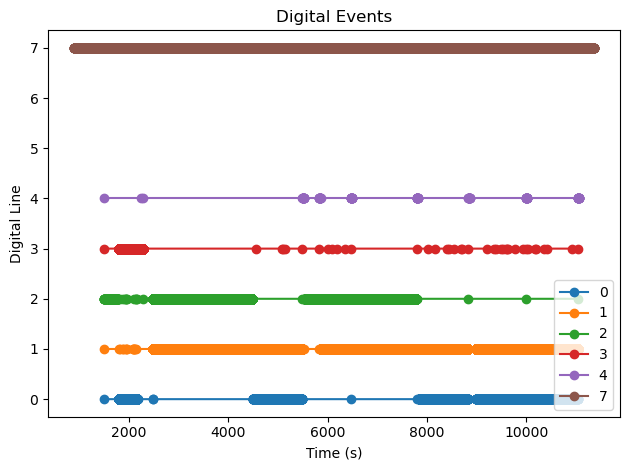

In [29]:
stim_data = StimData(recording_path)
dlines    = stim_data.digital_output

stim_data.plot()


*Per Stimulus Script*:  
**Line 1**: 
**Line 2**:  
**Line 6**: 
**Line 7**: 



## Stimuli Run During Experiment

In [ ]:
experiment_logs = glob(r'C:\Users\juans\github\color_and_form\data\C140\C140_20230921\*')

### Luminance Noise (Binary)

In [ ]:
identifier = 'binary_luminance'

for log in experiment_logs:
    if identifier in os.path.basename(log):
        fname = log
        
if 'pkl' in os.path.basename(fname):
    data = pkl.load(open(fname,'rb'))
    
nFrames        = data['nFrames']
dropped_frames = data['dropped_frames']
line           = data['dLine']

Plot difference between timestamps to ensure framelength matches expected frequency

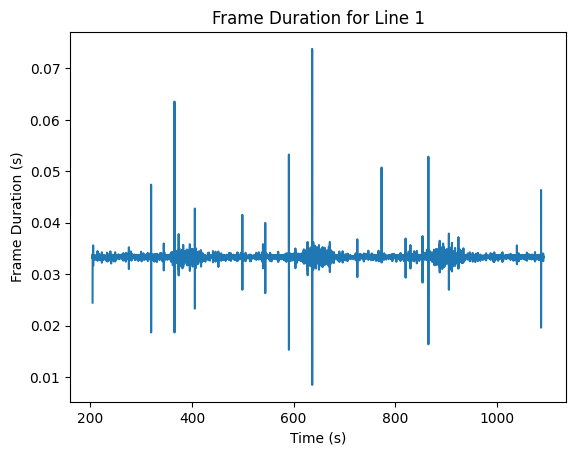

In [ ]:
fig,ax = plt.subplots()
ax.plot(dlines[str(line)][:nFrames][:-1],np.diff(dlines[str(line)][:nFrames]))
ax.set_ylabel('Frame Duration (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Frame Duration for Line {}'.format(line))
plt.show()

**Looks like script generated too many timestamps for the noise matrices and ran at 30Hz instead of 20Hz**

In [ ]:
def frames2list(frames):
    rows = []
    
    for frame in frames:
        rows.append(frame)
        
    return rows

In [ ]:
tsFrames = dlines[str(line)][:nFrames]

green_rows = frames2list(data['G'])
uv_rows    = frames2list(data['UV'])
noise_df = pd.DataFrame({'stim':'Binary Luminance Noise','start':tsFrames, 'green':green_rows,'uv':uv_rows,})

### Sweeping Bar

In [ ]:
identifier = 'bar_sweep'

for log in experiment_logs:
    if identifier in os.path.basename(log):
        fname = log
        
if 'pkl' in os.path.basename(fname):
    data = pkl.load(open(fname,'rb'))
    
    
dropped_frames = data['dropped_frames']
frameLine      = data['frameLine']
sweepLine      = data['sweepLine']
frames         = data['frames']
sweeps         = data['sweeps']

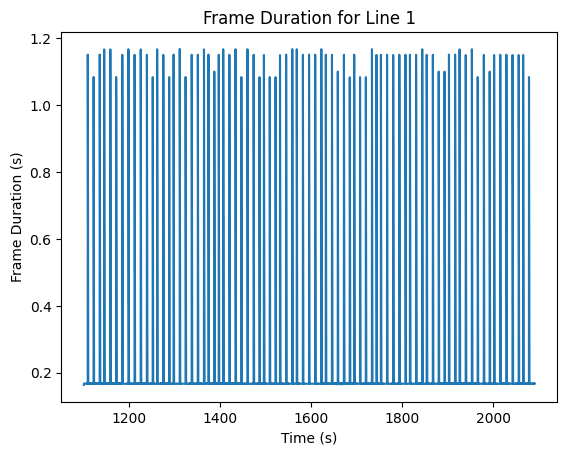

In [ ]:
fig,ax = plt.subplots()
ax.plot(dlines[str(frameLine)][nFrames:nFrames+5480][:-1],np.diff(dlines[str(frameLine)][nFrames:nFrames+5480]))
ax.set_ylabel('Frame Duration (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Frame Duration for Line {}'.format(line))
plt.show()

In [ ]:
sweep_df.head()

,stim,start,sweep,timestamp,ori,x,y
0,Sweeping Bar,1099.927933,0,0.036824,-90.0,-2.346173e-14,-383.159092
1,Sweeping Bar,1100.091133,0,0.199856,-90.0,-2.257303e-14,-368.645490
2,Sweeping Bar,1100.257267,0,0.365819,-90.0,-2.168432e-14,-354.131888
3,Sweeping Bar,1100.424700,0,0.533069,-90.0,-2.079562e-14,-339.618286
4,Sweeping Bar,1100.591333,0,0.699554,-90.0,-1.990692e-14,-325.104684


In [ ]:
tsFrames = dlines[str(frameLine)][nFrames:nFrames+5480]

sweep_df     = pd.DataFrame(data['frames'])
dummy_frames = frames2list(np.zeros((len(sweep_df),64,64))) #needed for nwb
sweep_df.insert(0,'start',tsFrames)
sweep_df.insert(0,'stim','Sweeping Bar')
sweep_df.insert(7,'green',dummy_frames)
sweep_df.insert(7,'uv',dummy_frames)
sweep_df.head()

,stim,start,sweep,timestamp,ori,x,y,uv,green
0,Sweeping Bar,1099.927933,0,0.036824,-90.0,-2.346173e-14,-383.159092,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Sweeping Bar,1100.091133,0,0.199856,-90.0,-2.257303e-14,-368.645490,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,Sweeping Bar,1100.257267,0,0.365819,-90.0,-2.168432e-14,-354.131888,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Sweeping Bar,1100.424700,0,0.533069,-90.0,-2.079562e-14,-339.618286,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Sweeping Bar,1100.591333,0,0.699554,-90.0,-1.990692e-14,-325.104684,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### Phosphor Noise (Ternary)

In [ ]:
identifier = 'ternary_phosphor'

for log in experiment_logs:
    if identifier in os.path.basename(log):
        fname = log
        
if 'pkl' in os.path.basename(fname):
    data = pkl.load(open(fname,'rb'))
    
nFrames        = data['nFrames']
dropped_frames = data['dropped_frames']
line           = data['dLine']

In [ ]:
26602+5480

32082

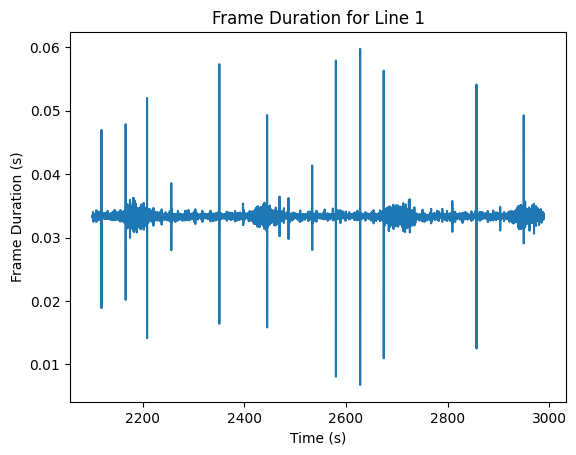

In [ ]:
fig,ax = plt.subplots()
ax.plot(dlines[str(line)][32082:32082+nFrames][:-1],np.diff(dlines[str(line)][32082:32082+nFrames]))
ax.set_ylabel('Frame Duration (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Frame Duration for Line {}'.format(line))
plt.show()

In [ ]:
tsFrames = dlines[str(line)][32082:32082+nFrames]


green_rows = frames2list(data['G'])
uv_rows    = frames2list(data['UV'])
noise_df2 = pd.DataFrame({'stim':'Ternary Phosphor Noise','start':tsFrames, 'green':green_rows,'uv':uv_rows,})

### Luminance Noise (Gaussian)

In [ ]:
nFrames+32082

58684

In [ ]:
identifier = 'gauss_luminance'

for log in experiment_logs:
    if identifier in os.path.basename(log):
        fname = log
        
if 'pkl' in os.path.basename(fname):
    data = pkl.load(open(fname,'rb'))
    
nFrames        = data['nFrames']
dropped_frames = data['dropped_frames']
line           = data['dLine']

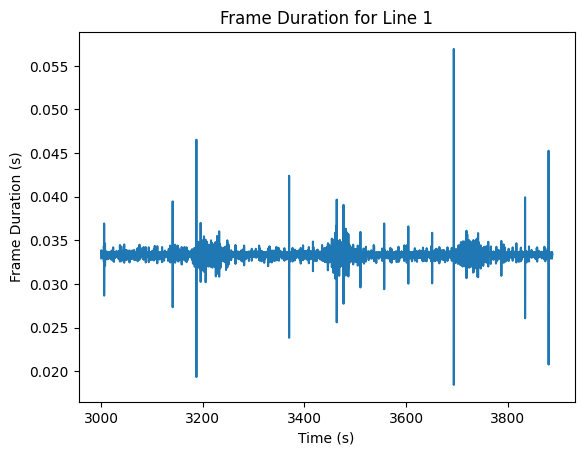

In [ ]:
fig,ax = plt.subplots()
ax.plot(dlines[str(line)][58684:58684+nFrames][:-1],np.diff(dlines[str(line)][58684:58684+nFrames]))
ax.set_ylabel('Frame Duration (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Frame Duration for Line {}'.format(line))
plt.show()

In [ ]:
tsFrames = dlines[str(line)][58684:58684+nFrames]

green_rows = frames2list(data['G'])
uv_rows    = frames2list(data['UV'])
noise_df3 = pd.DataFrame({'stim':'Gaussian Luminance Noise', 'start':tsFrames, 'green':green_rows,'uv':uv_rows,})

In [ ]:
stim_df = pd.concat([noise_df,sweep_df,noise_df2,noise_df3],ignore_index=True).sort_values(by='start')

In [ ]:
stim_df.to_json(os.path.join(int_path,'C140_stim.json'))